## PID Control
Reference:  
[1] http://y373.sakura.ne.jp/minami/pyctrl  
[2] "Pythonによる制御工学入門(第1版)", 南裕樹, オーム社  
[3] "Control Engineering: MATLAB Exercies", Laszlo.K et al, Springer

Let us assume that we have an arm rotating on the vertical plane. It is pinned to the wall and torque is applied to the arm from the pin. The angle of rotation is represented as $\theta$. The arm has moment of inertia $J$, mass $M$, and length $l$. Gravitational acceleration is $g$. Viscous torque is propotionally generated by anguler velocity $\dot{\theta}$, and viscosity coefficient is $\mu$.

Then, we get the equation of rotation as follows:
$$
J\ddot{\theta} = -\mu\dot{\theta} - Mgl\sin{\theta} + u(t)
$$

Assuming that the system is linearly representable, the above equation yields:
$$
J\ddot{\theta} + \mu\dot{\theta} + Mgl\theta = u(t) \\
(Js^2 + {\mu}s + Mgl)\Theta(s) = U(s) \\
\therefore P(s) = \frac{1}{Js^2 + {\mu}s + Mgl}
$$


Having the above equation, what if we want to control the angle of the arm by applying a well-conditioned torque? In this kind of case, PID control is most widely used to achieve it. PID control refers to a control technique to generates an appropreate input based on the error $e(t) = r(t) - y(t)$. $r(t)$ is a reference input. P, I, and D represent "proportional", "derivative" and "integral", respectively. Each control theory gererate an input such that $u(t) = k_{P}e(t)$, $u(t) = k_{I}\int_{0}^{t}e(\tau)d\tau$, $u(t) = k_{D}\dot{e}(t)$.

$$
u(t) = k_{P}e(t) + k_{I}\int_{0}^{t}e(\tau)d\tau + k_{D}\dot{e}(t) \\
U(s) = \frac{k_D s^2 + k_P s + k_I}{s}E(s) \\
\therefore K(s) = \frac{k_D s^2 + k_P s + k_I}{s}
$$

### P control
Let us see how P control behaves here. As we obtained the transfer functions of the controller and the plant, we get the transfer function of the closed loop as follows:

$$
G_{yr}(s) = \frac{P(s)K(s)}{1+P(s)K(s)} = \frac{k_P}{Js^2 + \mu s + (Mgl+k_P)}
$$

This turns into a standard form of a second order lag system:
$$
G_{yr}(s) = \frac{K\omega_n^2}{s^2+2\zeta\omega_ns+\omega_n^2} \\
K = \frac{k_P}{Mgl+k_P}, \zeta = \frac{\mu}{2\sqrt{J(Mgl+k_P)}}, \omega_n = \sqrt{\frac{Mgl+k_P}{J}}
$$

It is clear that the output is oscillating by P control. P control can improve the responsiveness of the system by increasing the gain $k_P$, but it sacrifices the damping of it at the same time.

In [1]:
import control.matlab as ctrl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

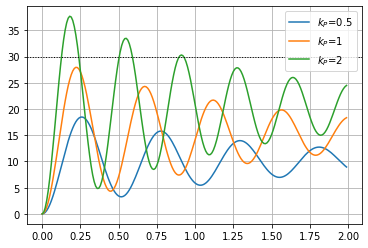

In [2]:
g = 9.81
l = 0.2
M = 0.5
mu = 1.5e-2
J = 1.0e-2

plant_num = [0, 1]
plant_den = [J, mu, M*g*l]
P = ctrl.tf(plant_num, plant_den)  # transfer function of the plant

ref = 30  # reference input of the angle

kp = (0.5, 1, 2)

for k in kp:
    num = [0, k]
    den = [0, 1]
    K = ctrl.tf(num, den)  # transfer function of the controller
    Gyr =  ctrl.feedback(K * P, 1)  # transfer function of the closed loop
    y, t = ctrl.step(Gyr, np.arange(0, 2, 0.01))  # step response of the above system (t=0.0~2.0)
    
    plt.plot(t, y*ref, label="$k_P$="+str(k))

plt.legend()
plt.axhline(ref, color="k", linewidth=1, ls=":")
plt.grid()
plt.show()

### PD control
We discussed the oscillating problem above. Then what if we add D control?

The transfer function of PD contol is represented as follows:
$$
K(s) = k_P + k_Ds
$$

Therefore, the transfer function of the closed loop is:
$$
G_{yr}(s) = \frac{P(s)K(s)}{1+P(s)K(s)} = \frac{k_Ds + k_P}{Js^2 + (\mu + k_D)s + (Mgl + k_P)}
$$

It is observable from the below figures that oscillation is mitigated by increasing the gain $k_D$. As we discussed above, the poles of the above equations are:
$$
s = \frac{-(\mu+k_D) \pm \sqrt{(\mu+k_D)^2 - 4J(Mgl+k_P)}}{2J}
$$
This shows that PD control allows us to improve damping and responsiveness at the same time since we have $k_P, k_D$ in both real and imaginary parts of them.

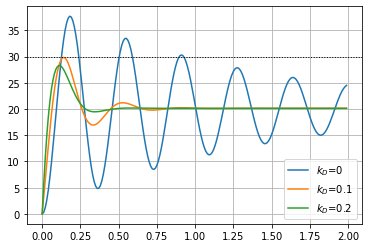

In [3]:
#PD control
kp = 2
kd = (0, 0.1, 0.2)

for k in kd:
    num = [k, kp]
    den = [0, 1]
    K = ctrl.tf(num, den)  # transfer function of the controller
    Gyr = ctrl.feedback(K*P, 1)
    y, t = ctrl.step(Gyr, np.arange(0, 2, 0.01))  # step response of the closed loop
    
    plt.plot(t, y*ref, label="$k_D$="+str(k))
    
plt.legend()
plt.axhline(ref, color="k", linewidth=1, ls=":")
plt.grid()
plt.show()

### PID control
We have discussed P, PD control above. Are they satisfactory to achieve a desired output? No. This can be easily shown by the final value theorem:

$$
y(\infty) = \lim_{s \to 0}sY(s)
$$

In P/PD control, 
$$
y(\infty) =  \lim_{s \to 0}s\frac{K\omega_n^2}{s^2+2\zeta\omega_ns+\omega_n^2}\times \frac{1}{s} = K
$$

This means that P/PD control cannot make the output converge to $y(\infty)=1$.

Let us introduce I control to solve this problem.

The transfer function of the controller is:
$$
K(s) = k_Ds + k_I\frac{1}{s} + k_P = \frac{k_Ds^2 + k_Ps + k_I}{s}
$$

This yields the transfer function of the closed loop as:
$$
G_{yr}(s) = \frac{k_Ds^2 + k_Ps + k_I}{Js^3 + (\mu + k_D)s^2 + (Mgl+k_P)s + k_I}
$$

Therefore, the step response with PID control converges to 1 because:
$$
y(\infty) = \lim_{s \to 0}sG_{yr}(s)\times\frac{1}{s} = \frac{k_I}{k_I} = 1
$$

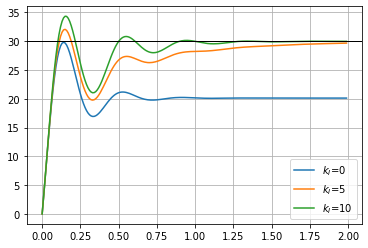

In [4]:
###PID control
kp = 2
kd = 0.1
ki = (0, 5, 10)

for k in ki:
    num = [kd, kp, k]
    den = [1, 0]
    K = ctrl.tf(num, den)
    
    Gyr = ctrl.feedback(K*P, 1)
    y, t = ctrl.step(Gyr, np.arange(0, 2, 0.01))
    
    plt.plot(t, y*ref, label="$k_I$="+str(k))
    
plt.legend()
plt.axhline(ref, color='k', linewidth=1)
plt.grid()
plt.show()